In [1]:
from modules import datasets
from modules import models

import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq

import matplotlib.pyplot as plt
from scipy.stats import linregress

Using TensorFlow backend.


In [2]:
db = datasets.load_halo_attributes('rockstar_sag_merge.csv')

In [3]:
MhaloMin=11 ###Log10 de masa mínima de halo permitida (en Msun)
dmh=0.25 ##Delta Masa Halo
nmh=21 ###Numero de bines de masas de halo

a=db['MstarSpheroid']+db['MstarDisk']
db['LogMstarSum']=np.log10(a)
db['LogMHalo'] = np.log10(db['HaloMass'])


### Me quedo con las galaxias con Mh>=10
db = db.loc[db['LogMHalo'] >= MhaloMin]

ngx=len(db)

for coso in db:
    print(coso)


row_id_x
rockstarId
nprog
Mvir_SAM
Mvir
Rvir
Rs
Vrms
angMom_x
angMom_y
angMom_z
spin
Xoff
axisratio_2_1
axisratio_3_1
Macc
row_id_y
HaloMass
Vmax
Vpeak
concentration_NFW
MstarSpheroid
MstarDisk
LogMstarSum
LogMHalo


In [4]:
avlMh=[] ##Log10 Masa del halo (x) promedio para el bin i
avlMst=[]##Log10 Masa estelar (y(x)) promedio para el bin i
nmhbin=[] ##Número de masas en el bin i
bin_lims=[]

for i in range(nmh):
    avlMh.append(0)
    avlMst.append(0)
    nmhbin.append(0)
    
    ##Creo vectores nmh-Dimensional para cada cubrir cada bin

x=0

for index, row in db.iterrows():
    ibin=int((row['LogMHalo']-MhaloMin)/dmh)
    nbin=ibin+1
    
    if nbin>nmh:
        continue
    else:
        nmhbin[ibin]+=1
        avlMst[ibin]+= row['LogMstarSum']
        avlMh[ibin]+=row['LogMHalo']

        
bin_lims=[]
for i in range(nmh):
    bin_lims.append(MhaloMin+i*dmh)

print(bin_lims)
    
        

        
avlMh=np.array(avlMh)
avlMst=np.array(avlMst)
nmhbin=np.array(nmhbin)


avlMh = avlMh/nmhbin
avlMst = avlMst/nmhbin

[11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0]


/home/cris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/cris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [5]:
nmhbin = np.trim_zeros(nmhbin)

avlMh = np.nan_to_num(avlMh)
avlMh = np.trim_zeros(avlMh)

avlMst = np.nan_to_num(avlMst)
avlMst = np.trim_zeros(avlMst)

###Estoy eliminando las casillas con 0 y NaN

In [6]:
pairs = np.array([avlMh,avlMst])
pairs = pairs.transpose()

slope_inter=[]

for i in range(len(pairs)-1):
    x1 = pairs[i]
    x2 = pairs[i+1]
    
print((pairs))
for i in range(len(pairs)-1):
    x1= pairs[i][0]
    y1= pairs[i][1]
    x2= pairs[i+1][0]
    y2= pairs[i+1][1]
    
    m = (y2-y1)/(x2-x1)
    n = y1-m*x1
    slope_inter.append([m,n])

[[11.16662668  9.51130886]
 [11.40806498  9.59610131]
 [11.63941663  9.90935357]
 [11.87284644 10.21135634]
 [12.11571045 10.43559481]
 [12.36457044 10.59704192]
 [12.61415801 10.74812895]
 [12.8620884  10.89544042]
 [13.11113022 11.03920802]
 [13.36160364 11.19775335]
 [13.61230504 11.3526155 ]
 [13.85771289 11.51649239]
 [14.11379655 11.67948612]
 [14.35811775 11.85167968]
 [14.60359232 11.98850056]
 [14.84522418 12.2809541 ]
 [15.13723724 12.40604523]]


In [7]:
print(len(slope_inter))
bin_lims1 = bin_lims[1:len(slope_inter)+2]
print(bin_lims1)

16
[11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25]


In [8]:

print(len(avlMst))
print(len(slope_inter))

17
16


In [9]:
def Mstar_interpolator(Mhalo, mass_averages, line_parameters):
    
    #### len(line_parameters) = len(mass_averages)-1
    
    for i in range(len(line_parameters)):
        
        if Mhalo < mass_averages[i+1]:
            
            m = line_parameters[i][0]
            n = line_parameters[i][1]
                   
            Mstar = m*Mhalo + n
            return(Mstar)
                   
                   
    m = line_parameters[-1][0]
    n = line_parameters[-1][1]
    Mstar = m*Mhalo + n
    return(Mstar)  

In [10]:
interpMst=[]
deltaMst=[]


for index, row in db.iterrows():
    
    inter = Mstar_interpolator(row['LogMHalo'], avlMh, slope_inter)
    interpMst.append(inter)
    deltaMst.append(row['LogMstarSum'] - inter)
    
db['deltaMst'] = deltaMst
db['interpMst'] = interpMst

db.to_csv('filtered_delta.csv', index = False)

No handles with labels found to put in legend.


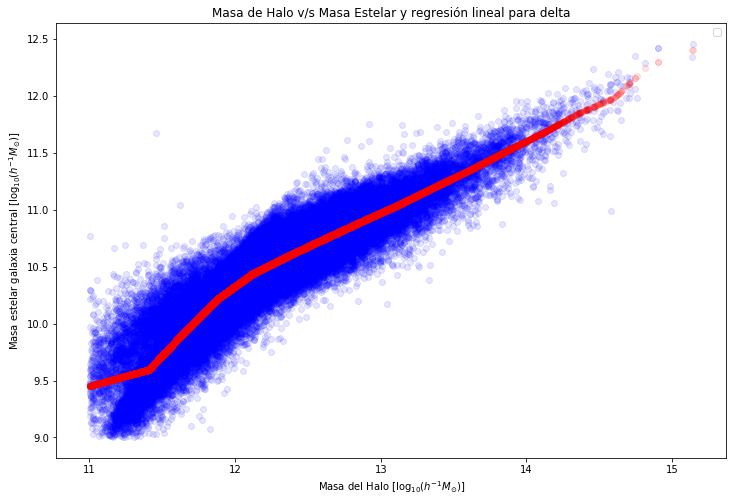

In [11]:

fig, ax = plt.subplots(figsize=(12,8))
#binhs = np.array([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])*2

ax.scatter(db['LogMHalo'],db['LogMstarSum'],c='blue',alpha=0.1)
ax.scatter(db['LogMHalo'],interpMst,c='red',alpha=0.1)


ax.set_xlabel('Masa del Halo [$\log_{10}(h^{-1}M_{\odot}$)]')
ax.set_ylabel('Masa estelar galaxia central [$\log_{10}(h^{-1}M_{\odot}$)]')
ax.set_title('Masa de Halo v/s Masa Estelar y regresión lineal para delta')
ax.legend()
#ax.set_xticks(binhs)
plt.savefig('estelar vs halo.png')
plt.show()


In [12]:
for name, data in db.iteritems():
    print(name+'. Min = '+str(np.min(data))+'; Max = ' + str(np.max(data)))

row_id_x. Min = 14; Max = 999740
rockstarId. Min = 12074074911; Max = 12076896217
nprog. Min = 1; Max = 52
Mvir_SAM. Min = 192690000; Max = 118960000000000
Mvir. Min = 192690000; Max = 117630000000000
Rvir. Min = 11.753; Max = 996.967
Rs. Min = 0.054000000000000006; Max = 519.0880000000002
Vrms. Min = 0.0; Max = 835.85
angMom_x. Min = -872700000000000.0; Max = 4444000000000000.0
angMom_y. Min = -1059000000000000.0; Max = 2229000000000000.0
angMom_z. Min = -514500000000000.0; Max = 1256000000000000.0
spin. Min = 0.0; Max = 3.08682
Xoff. Min = 0.0018; Max = 189.016
axisratio_2_1. Min = 0.0; Max = 0.99874
axisratio_3_1. Min = 0.0; Max = 0.98915
Macc. Min = 192690000; Max = 117630000000000
row_id_y. Min = 1; Max = 100000
HaloMass. Min = 100860000000.0; Max = 1378900000000000.0
Vmax. Min = 78.14; Max = 1942.67
Vpeak. Min = 78.14; Max = 1942.67
concentration_NFW. Min = 0.537562; Max = 220.596
MstarSpheroid. Min = 1000120000; Max = 2885760000000
MstarDisk. Min = 0.0; Max = 326966000000.0
LogM